### Mount Drive and create insital structre








In [1]:
from google.colab import drive
from pathlib import Path

drive.mount('/content/drive')

BASE_DIR = Path('/content/drive/MyDrive/Music_Genre_Classification/MagnaTagATune')
BASE_DIR.mkdir(parents=True, exist_ok=True)
RAW_DIR  = BASE_DIR / 'OpenDataLab___MagnaTagATune' / 'raw'
AUDIO_DIR = BASE_DIR / 'audio'
chunks_path = BASE_DIR / 'mtat_spectrogram_chunks.csv'

Mounted at /content/drive


### Define and normalize Tags into main Genres 

In [2]:
import numpy as np
import pandas as pd
# Map raw tags -> canonical genre
GENRE_CANONICAL = {
    'rock': 'rock',
    'metal': 'metal',
    'punk': 'rock',        # optional: merge into rock

    'pop': 'pop',

    'electronic': 'electronic',
    'electro': 'electronic',
    'techno': 'electronic',
    'trance': 'electronic',
    'house': 'electronic',

    'hiphop': 'hiphop',
    'hip-hop': 'hiphop',
    'rap': 'hiphop',

    'classical': 'classical',
    'orchestral': 'classical',

    'jazz': 'jazz',
    'blues': 'jazz',       # could merge into jazz

    'folk': 'folk',
    'country': 'folk',     # optional merge

    'ambient': 'ambient',
    'drone': 'ambient',    # optional
}

GENRE_TAGS = set(GENRE_CANONICAL.keys())
df = pd.read_csv(chunks_path)
df['img_path'] = df['img_path'].astype(str)

In [3]:
def extract_main_genre(tags_str: str):
    if not isinstance(tags_str, str):
        return np.nan
    tags = [t.strip().lower() for t in tags_str.split()]
    genres = {GENRE_CANONICAL[t] for t in tags if t in GENRE_TAGS}
    if len(genres) == 1:
        return list(genres)[0]
    else:
        return np.nan

df_gen = df.copy()
df_gen['main_genre'] = df_gen['tags'].apply(extract_main_genre)
df_gen.head()


,img_path,tags,split,main_genre
0,/content/drive/MyDrive/Music_Genre_Classificat...,female vocals woman foreign tribal,train,NaN
1,/content/drive/MyDrive/Music_Genre_Classificat...,female vocals woman foreign tribal,train,NaN
2,/content/drive/MyDrive/Music_Genre_Classificat...,female vocals woman foreign tribal,train,NaN
3,/content/drive/MyDrive/Music_Genre_Classificat...,female vocals woman foreign tribal,train,NaN
4,/content/drive/MyDrive/Music_Genre_Classificat...,techno electronic,train,electronic


In [4]:
df_gen = df_gen.dropna(subset=['main_genre']).reset_index(drop=True)
df_gen['main_genre'].value_counts()


,count
main_genre,
classical,16592
electronic,11460
rock,5016
ambient,4968
pop,1572
folk,1504
jazz,1252
hiphop,172
metal,48


In [5]:
min_count = 1000
valid_genres = df_gen['main_genre'].value_counts()
valid_genres = valid_genres[valid_genres >= min_count].index.tolist()

df_gen = df_gen[df_gen['main_genre'].isin(valid_genres)].reset_index(drop=True)
df_gen['main_genre'].value_counts()


,count
main_genre,
classical,16592
electronic,11460
rock,5016
ambient,4968
pop,1572
folk,1504
jazz,1252


### Splitting

In [6]:
df_tv_gen = df_gen[df_gen['split'].isin(['train', 'valid'])].copy()
df_tv_gen['is_valid'] = df_tv_gen['split'] == 'valid'
df_tv_gen['img_path'] = df_tv_gen['img_path'].astype(str)

df_test_gen = df_gen[df_gen['split'] == 'test'].copy()
df_test_gen['img_path'] = df_test_gen['img_path'].astype(str)

len(df_tv_gen), len(df_test_gen), df_tv_gen['main_genre'].value_counts()


(37976,
 4388,
 main_genre
 classical     14952
 electronic    10360
 rock           4416
 ambient        4412
 pop            1384
 folk           1324
 jazz           1128
 Name: count, dtype: int64)

In [14]:
single_label_csv = BASE_DIR / 'mtat_singlelabel_genres.csv'
df_gen.to_csv(single_label_csv, index=False)
single_label_csv

PosixPath('/content/drive/MyDrive/Music_Genre_Classification/MagnaTagATune/mtat_singlelabel_genres.csv')

### Define SpecAugment && Data Block

In [7]:
from fastai.vision.all import *
import random

class SpecAugment(RandTransform):
    "Simple SpecAugment-like masking on spectrogram images (train only)."
    split_idx = 0   # 🔥 only apply on training

    def __init__(
        self,
        time_mask_frac=0.05,
        freq_mask_frac=0.05,
        n_time_masks=1,
        n_freq_masks=1,
        p=0.5,
        **kwargs
    ):
        super().__init__(p=p, **kwargs)
        self.time_mask_frac = time_mask_frac
        self.freq_mask_frac = freq_mask_frac
        self.n_time_masks = n_time_masks
        self.n_freq_masks = n_freq_masks

    def _apply_to_single(self, x:TensorImage):
        "Apply time/freq masks to a single image of shape (C,H,W)."
        c, h, w = x.shape

        # Frequency masks (horizontal bands)
        for _ in range(self.n_freq_masks):
            mask_height = int(self.freq_mask_frac * h)
            if mask_height < 1:
                continue
            f0 = random.randint(0, max(0, h - mask_height))
            x[:, f0:f0+mask_height, :] = 0.

        # Time masks (vertical bands)
        for _ in range(self.n_time_masks):
            mask_width = int(self.time_mask_frac * w)
            if mask_width < 1:
                continue
            t0 = random.randint(0, max(0, w - mask_width))
            x[:, :, t0:t0+mask_width] = 0.

        return x

    def encodes(self, x:TensorImage):
        # x can be (C,H,W) or (B,C,H,W)
        if x.ndim == 3:
            return self._apply_to_single(x)
        elif x.ndim == 4:
            for i in range(x.shape[0]):
                x[i] = self._apply_to_single(x[i])
            return x
        else:
            return x


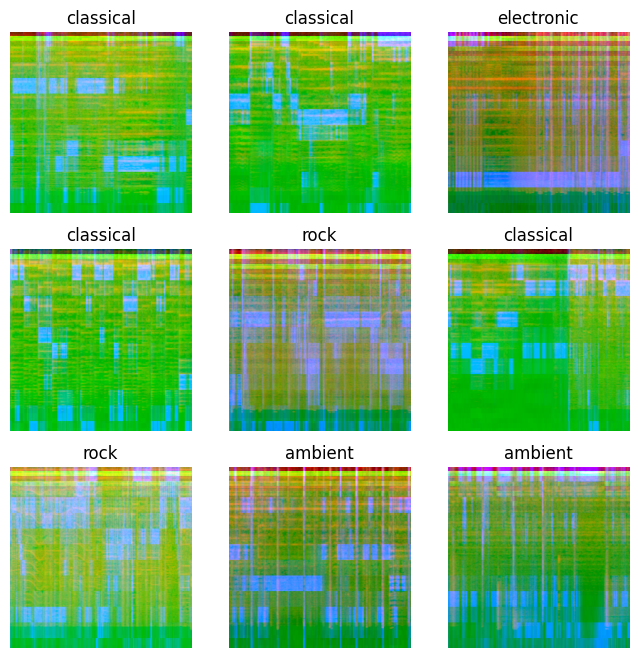

In [10]:
genre_block = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_x=ColReader('img_path'),
    get_y=ColReader('main_genre'),
    splitter=ColSplitter('is_valid'),
    item_tfms=Resize(256),   # good compromise for effnet_b4
    batch_tfms=[
        SpecAugment(
            time_mask_frac=0.05,
            freq_mask_frac=0.05,
            n_time_masks=1,
            n_freq_masks=1,
            p=0.5,
        ),
        Normalize.from_stats(*imagenet_stats),
    ]
)

dls_gen = genre_block.dataloaders(df_tv_gen, bs=64)
dls_gen.show_batch(max_n=9, figsize=(8, 8))


### Train the model

In [11]:
learn_gen_b4 = vision_learner(
    dls_gen,
    'efficientnet_b4',
    metrics=accuracy
).to_fp16()

learn_gen_b4.fine_tune(20, base_lr=2e-4)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/77.9M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,accuracy,time
0,1.172424,0.856226,0.738443,16:24


epoch,train_loss,valid_loss,accuracy,time
0,1.066721,0.818793,0.754009,01:58
1,1.007493,0.795976,0.765094,01:53
2,0.956353,0.771334,0.762264,01:54
3,0.885440,0.737237,0.773113,01:53
4,0.890582,0.741341,0.764151,01:53
5,0.808106,0.706212,0.770519,01:54
6,0.806812,0.692865,0.777358,01:53
7,0.772443,0.674307,0.782311,01:54
8,0.736968,0.681640,0.779717,01:55
9,0.699911,0.660257,0.775236,01:54


### Evaluation

In [12]:
test_dl_gen_b4 = dls_gen.test_dl(df_test_gen, with_labels=True)
preds_b4, targs_b4 = learn_gen_b4.get_preds(dl=test_dl_gen_b4)
acc_test_b4 = accuracy(preds_b4, targs_b4).item()
acc_test_b4


0.7837283611297607

In [13]:
MODELS_DIR = BASE_DIR / 'models'
MODELS_DIR.mkdir(parents=True, exist_ok=True)
learn_gen_b4.save(MODELS_DIR / 'effnet_b4_MagnaTagATune_v2_single_label')

# Full export (includes architecture + preprocessing)
learn_gen_b4.export(MODELS_DIR / 'effnet_b4_MagnaTagATune_v2_single_label.pkl')
MODELS_DIR

Path('/content/drive/MyDrive/Music_Genre_Classification/MagnaTagATune/models')

### Save Model

In [2]:
from fastai.vision.all import *
from pathlib import Path
import pandas as pd

BASE_DIR   = Path('/content/drive/MyDrive/Music_Genre_Classification/MagnaTagATune')
MODELS_DIR = BASE_DIR / 'models'

learn_gen_b4 = load_learner(MODELS_DIR / 'effnet_b4_MagnaTagATune_v2_single_label.pkl')
learn_gen_b4


/usr/local/lib/python3.12/dist-packages/fastai/learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")


### Generate Confision Matrix

In [3]:
single_label_csv = BASE_DIR / 'mtat_singlelabel_genres.csv'
df_gen_clean = pd.read_csv(single_label_csv)

# Ensure paths are strings
df_gen_clean['img_path'] = df_gen_clean['img_path'].astype(str)

# Test split only
df_test_gen = df_gen_clean[df_gen_clean['split'] == 'test'].copy().reset_index(drop=True)
len(df_test_gen), df_test_gen['main_genre'].value_counts()


(4388,
 main_genre
 classical     1640
 electronic    1100
 rock           600
 ambient        556
 pop            188
 folk           180
 jazz           124
 Name: count, dtype: int64)

In [4]:
test_dl_gen_b4 = learn_gen_b4.dls.test_dl(df_test_gen, with_labels=True)


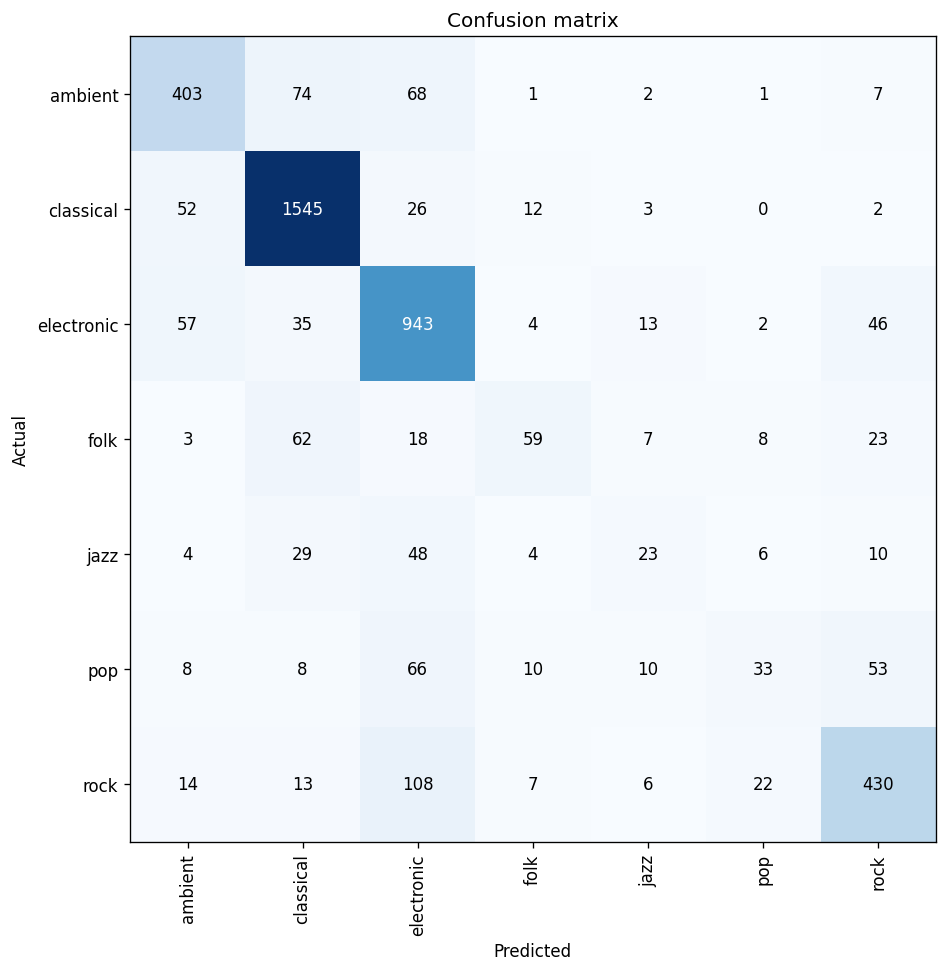

In [5]:
interp = ClassificationInterpretation.from_learner(learn_gen_b4, dl=test_dl_gen_b4)
interp.plot_confusion_matrix(figsize=(8, 8), dpi=120)
